# Additional collection-wide analysis

In [2]:
import re
import sys
import tarfile
import warnings

from lxml import etree
import numpy as np
import pandas as pd

import genizahdata as gd

# Suppress warnings about messy metadata
warnings.filterwarnings('ignore', category=gd.GenizahDataWarning)

We'll use Vega/Altair for graphical visualisation

In [996]:
import altair as alt

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [422]:
bundle = tarfile.open('../medical-data/genizah-tei.tar.lz')

data = pd.DataFrame.from_records(
    (gd.get_data(path, root) for path, root in gd.extract_tar_xml(bundle)),
    index='classmark')
data.head()

,columns,date_end,date_start,height,lines,material,summary,title,width
classmark,,,,,,,,,
MS-ADD-03430,1.0,1028-12-31,1028-01-01,NaN,37.0,vellum,Karaite ketubba for Sarwa bat Ṣedaqa b. Jarīr ...,Legal document: ketubba,NaN
MS-MOSSERI-I-A-00002,1.0,1051-12-31,1051-01-01,NaN,38.0,paper,Karaite betrothal deed for Yamān bat David b. ...,Legal document,NaN
MS-OR-01080-00001-00001,1.0,1899-12-31,0500-01-01,NaN,17.0,paper,Piyyuṭim on parašot Toldot to Qedošim (Genesis...,Piyyuṭ,NaN
MS-OR-01080-00001-00003,1.0,1199-12-31,1000-01-01,NaN,15.0,paper,"Various piyyuṭim, as well as divorce and marri...",Piyyuṭ; liturgy; legal document,NaN
MS-OR-01080-00001-00004,1.0,1899-12-31,0500-01-01,NaN,22.0,paper,Piyyuṭim.,Piyyuṭ,NaN


## Missing metadata

It'd be interesting to get a feel for how much of the collection has descriptive metadata.

Informally we know the collection has very varying levels of metadata coverage.

In [997]:
# Certainly plenty of items with blank fields:
len(data), (pd.isna(data['columns'])).sum()

(23006, 2242)

Items with the most missing fields:

In [54]:
data.reindex(index=(~data.isna()).sum(axis=1).sort_values().index).head()

,columns,date_end,date_start,height,lines,material,summary,title,width
classmark,,,,,,,,,
MS-TS-MISC-00028-00155,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN
MS-OR-01080-J-00190,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN
MS-OR-01080-J-00187,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN
MS-OR-01080-J-00186,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN
MS-OR-01080-J-00185,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN


The title and dates have placeholder default values. The start date 0500-01-01 and end date 1899-12-31 are defaults if a more exact date is not known.

In [85]:
import re

def drop_default_values(genizah_df):
    return genizah_df.replace(to_replace={
        'date_start': {'0500-01-01': None},
        'date_end': {'1899-12-31': None},
        'title': {'Genizah Fragment': None},
        'summary': {re.compile('^\s*$'): None}})

How many items have no (real) metadata?

In [1003]:
_blank_items = ((~drop_default_values(data).isna()).sum(axis=1) == 0).sum()
print(f'{_blank_items} items are blank ({_blank_items / data.shape[0]:.1%}) ')

1842 items are blank (8.0%) 


Perhaps breaking down items by the number of blank fields per item is useful:

In [1006]:
missing_data = drop_default_values(data).isna()
value_count = len(missing_data.columns)
missing_data['missing_fields'] = missing_data.sum(axis='columns')
missing_data.head()

,columns,date_end,date_start,height,lines,material,summary,title,width,missing_fields
classmark,,,,,,,,,,
MS-ADD-03430,False,False,False,True,False,False,False,False,True,2
MS-MOSSERI-I-A-00002,False,False,False,True,False,False,False,False,True,2
MS-OR-01080-00001-00001,False,True,True,True,False,False,False,False,True,4
MS-OR-01080-00001-00003,False,False,False,True,False,False,False,False,True,2
MS-OR-01080-00001-00004,False,True,True,True,False,False,False,False,True,4


Plot the proportion of fields which are blank over the collection (broken down by number of blank fields per item):

In [1010]:
missing_by_type = (missing_data.reset_index()
 .melt(id_vars='classmark', 
       value_vars=('columns date_end date_start height'
                   ' lines material summary title width').split(), var_name='field', value_name='num_missing')
 .groupby('field')
 .sum())
missing_by_type['missing_fields'] = 'All documents'
missing_by_type['group_size'] = missing_data.shape[0]

missing_by_type_breakdown = (missing_data.reset_index()
 .melt(id_vars='classmark missing_fields'.split(), 
       value_vars=('columns date_end date_start height'
                   ' lines material summary title width').split(), var_name='field', value_name='num_missing')
 .groupby(['missing_fields', 'field'])
 .sum().reset_index(level=1))

missing_by_type_breakdown = pd.merge(
    missing_by_type_breakdown, 
    pd.DataFrame(missing_data.groupby('missing_fields').size().rename('group_size')),
    left_on='missing_fields', right_on='missing_fields')

missing = pd.concat([missing_by_type.reset_index(), missing_by_type_breakdown.reset_index()], 
                    ignore_index=True, sort=False)
missing['pct_missing'] = missing['num_missing'] / missing['group_size']


display(missing.head(), missing.tail())

,field,num_missing,missing_fields,group_size,pct_missing
0,columns,2242.0,All documents,23006,0.097453
1,date_end,18551.0,All documents,23006,0.806355
2,date_start,18523.0,All documents,23006,0.805138
3,height,5047.0,All documents,23006,0.219378
4,lines,2242.0,All documents,23006,0.097453


,field,num_missing,missing_fields,group_size,pct_missing
76,lines,1842.0,9,1842,1.0
77,material,1842.0,9,1842,1.0
78,summary,1842.0,9,1842,1.0
79,title,1842.0,9,1842,1.0
80,width,1842.0,9,1842,1.0


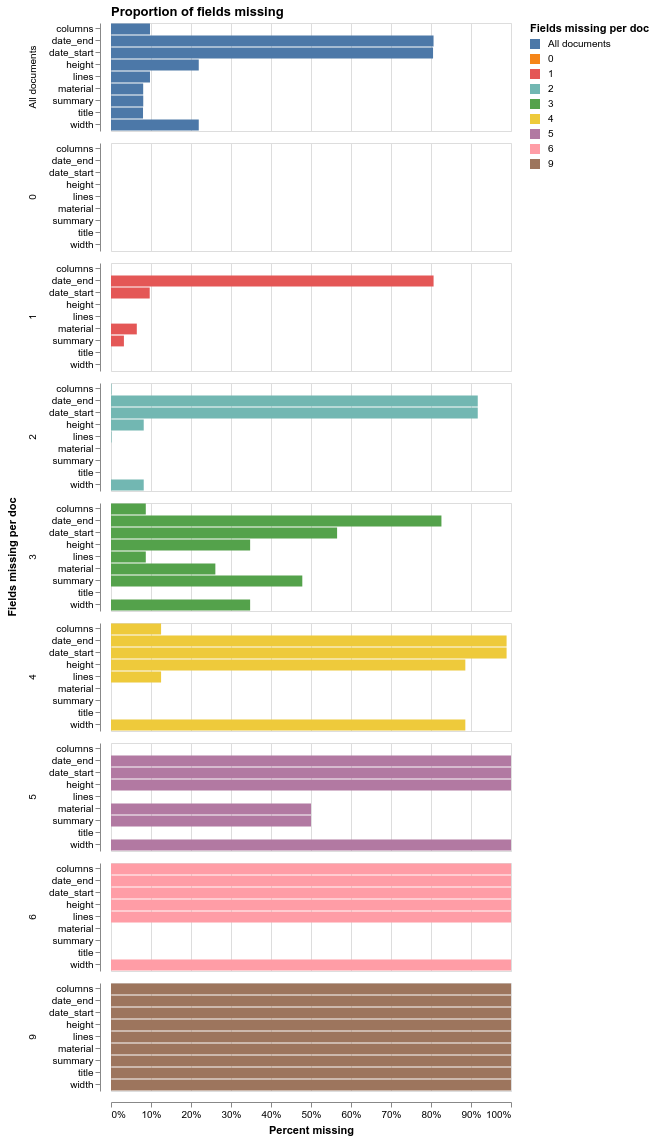

In [1012]:
(alt.Chart(missing.rename(columns=dict(missing_fields='Fields missing per doc',
                                       pct_missing='Percent missing',
                                       group_size='Group size')), title='Proportion of fields missing')
    .mark_bar(orient='vertical')
    .encode(alt.Y('field:N', title=None, scale=alt.Scale(rangeStep=12)),
            alt.X('Percent missing:Q', axis=alt.Axis(format='%')),
            row='Fields missing per doc:N',
            color=alt.Color('Fields missing per doc:N'),
            tooltip=[alt.Tooltip('Percent missing', format='.1%'),
                     alt.Tooltip('Group size')]))

A problem with the above is that the groups vary in size a lot, and the difference in size is not reflected. E.g. group 4 and 5 look similar, but 5 contains only 2 items.

In [1013]:
missing_by_var = missing_data.melt(id_vars='missing_fields', var_name='field').groupby(['missing_fields', 'field'])


missing = pd.concat([missing_by_var.sum().rename(columns=dict(value='docs_without_field')),
                     missing_by_var.count().rename(columns=dict(value='docs_without_n_fields'))], axis=1)

# The proportion of all missing values which are type X
missing['var_weight'] = (missing[['docs_without_field']] / 
                         missing[['docs_without_field']].sum(level=0))
# The group with 0 missing values have NaN weight due division by zero - we'll use
# zero weighting for all value types in this case as none are missing.
missing.loc[0, 'var_weight'] = 0

# I the breakdown of types missing to match the quantity of documents in
# each type, so that the viewer sees the parallel between values missing and
# 

# We want to present the fraction of values missing by type (in groups of
# documents with N values missing) to be proportional to the number of
# affected documents. Partly so that the user sees the parallel between the
# number-of-documents-with-N-values-missing graph and the missing values
# breakdown, but also so that bands large bands really indicate large numbers
# of missing values.
missing['var_size'] = missing['docs_without_n_fields'] * missing['var_weight']

missing.loc[2]

,docs_without_field,docs_without_n_fields,var_weight,var_size
field,,,,
columns,21.0,15881,0.000661,10.5
date_end,14561.0,15881,0.458441,7280.5
date_start,14561.0,15881,0.458441,7280.5
height,1299.0,15881,0.040898,649.5
lines,21.0,15881,0.000661,10.5
material,0.0,15881,0.000000,0.0
summary,0.0,15881,0.000000,0.0
title,0.0,15881,0.000000,0.0
width,1299.0,15881,0.040898,649.5


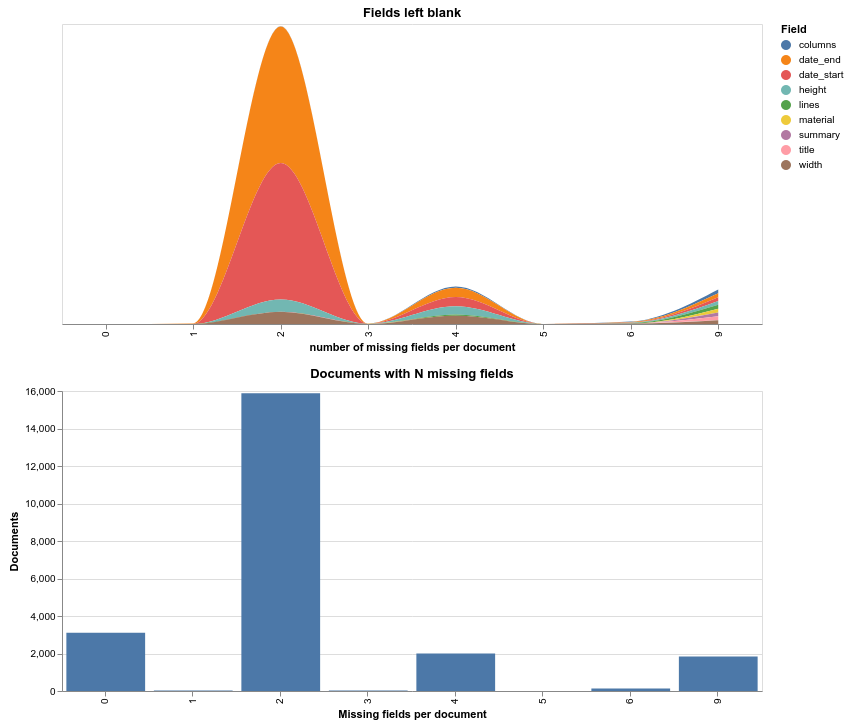

In [1023]:
from altair import datum


chart = alt.Chart(missing.reset_index().rename(columns=dict(field='Field')), width=700)
upper = (chart.properties(title='Fields left blank')
    .mark_area(interpolate='monotone')
    .encode(x=alt.X('missing_fields:O',
                    title='number of missing fields per document'),
            y=alt.Y(aggregate='sum', field='var_size', type='quantitative', #stack='normalize', 
                    axis=None),
            color='Field'
    )
)

lower = (chart.properties(title='Documents with N missing fields')
    .mark_bar(interpolate='monotone')
    .encode(x=alt.X('missing_fields:O', title='Missing fields per document'),
            y=alt.Y(field='Documents', type='quantitative')
    )
    .transform_aggregate(Documents='max(docs_without_n_fields)', groupby=['missing_fields']))

upper & lower

We can see that dates make up the bulk of missing data, followed by height and width of items.

# Item relationships

In [04-data-visualisation](04-data-visualisation.ipynb) we tried to find associations between items by finding co-occuring terms in their descriptions. Another approach is to use use clustering methods to group items. We'll use k-means, applied to the item descriptions in a bag-of-words representation - each document occupies a point in n-dimentional space, where n is the number of words in the entire corpus of descriptions.

In [1026]:
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [1027]:
descriptions = drop_default_values(data[['summary']])['summary'].dropna()

display(descriptions.head(), descriptions.size)

classmark
MS-ADD-03430               Karaite ketubba for Sarwa bat Ṣedaqa b. Jarīr ...
MS-MOSSERI-I-A-00002       Karaite betrothal deed for Yamān bat David b. ...
MS-OR-01080-00001-00001    Piyyuṭim on parašot Toldot to Qedošim (Genesis...
MS-OR-01080-00001-00003    Various piyyuṭim, as well as divorce and marri...
MS-OR-01080-00001-00004                                            Piyyuṭim.
Name: summary, dtype: object

21151

Convert descriptions to word vectors...

In [486]:
vectoriser = CountVectorizer()

corpus = vectoriser.fit_transform(list(descriptions))
corpus

<21151x17967 sparse matrix of type '<class 'numpy.int64'>'
	with 302461 stored elements in Compressed Sparse Row format>

We apply TF IDF to boost significant terms, and supress less significant terms.

In [495]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(corpus)
tfidf

<21151x17967 sparse matrix of type '<class 'numpy.float64'>'
	with 302461 stored elements in Compressed Sparse Row format>

We can see the corpus-wide (inverse document frequency) weights found for the terms:

In [1030]:
from IPython.core.display import Markdown

_tokens = pd.DataFrame.from_records(list(vectoriser.vocabulary_.items()), 
                          columns=['token', 'index'], index='index').sort_index()
_weights = pd.DataFrame({'idf_weight': transformer.idf_})

_global_term_weights = pd.concat([_tokens, _weights], axis=1).sort_values('idf_weight')

display(Markdown('### Less significant terms'), _global_term_weights.head(10),
        Markdown('### More significant terms'), _global_term_weights.tail(10))

### Less significant terms

,token,idf_weight
index,,
12768,the,1.847755
9242,of,1.867708
2073,and,1.912963
6588,in,2.469462
5578,for,2.496119
12893,to,2.538147
9291,on,2.626219
13645,with,2.670453
5685,from,2.701326


### More significant terms

,token,idf_weight
index,,
1918,aleppians,10.266343
9711,pericopes,10.266343
9713,periodicity,10.266343
1916,aleman,10.266343
9717,perishing,10.266343
9718,permanent,10.266343
9719,permissibility,10.266343
1915,alefs,10.266343
1913,aldabi,10.266343


In [1031]:
# TODO/CONTINUE: Describe use of latent semantic analysis

In [529]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

svd = TruncatedSVD(100)
normaliser = Normalizer(copy=False)
lsa = make_pipeline(svd, normaliser)

In [530]:
reduced = lsa.fit_transform(tfidf)
reduced

array([[ 0.33861522, -0.17521939,  0.07084558, ..., -0.02753214,
         0.04113121,  0.0579903 ],
       [ 0.53563748, -0.30461449,  0.12219621, ..., -0.07057174,
         0.07234704, -0.01345111],
       [ 0.30029966, -0.22505522,  0.09772828, ...,  0.02875516,
         0.0635143 ,  0.07127276],
       ...,
       [ 0.63612274,  0.34452323, -0.37032483, ..., -0.05520415,
        -0.00089396,  0.03004672],
       [ 0.56247264,  0.38852514, -0.12699196, ...,  0.03025173,
        -0.04767629,  0.00278576],
       [ 0.60049344,  0.30127116, -0.33650485, ..., -0.0361008 ,
        -0.01733741,  0.02676067]])

In [532]:
reduced.shape

(21151, 100)

In [667]:
from sklearn.cluster import KMeans

n_clusters = 80

km = KMeans(n_clusters=n_clusters)
km.fit(reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=80, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [808]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
display(original_space_centroids)
original_space_centroids.shape

array([[ 2.45066183e-04,  1.16078142e-04, -1.04910242e-04, ...,
         3.58427024e-04,  1.99755283e-04,  6.20109157e-04],
       [ 9.48441906e-06, -8.58178032e-06,  5.53339778e-07, ...,
        -7.53201990e-06, -7.32773757e-07, -3.31926972e-06],
       [-3.85685032e-05, -4.61903086e-06,  2.17519028e-05, ...,
        -1.10618194e-05,  2.09910447e-06,  8.87306430e-05],
       ...,
       [ 2.33472455e-05,  2.03412324e-05,  8.15379769e-06, ...,
        -2.06313148e-05,  2.12387474e-05,  7.87338102e-05],
       [ 2.15980505e-04, -1.88977185e-05,  1.39830577e-04, ...,
         1.26583489e-04, -7.86479381e-06,  1.21274845e-03],
       [-6.31086020e-06,  8.70278907e-06,  2.33392929e-06, ...,
         2.03992692e-05,  1.15080390e-06,  8.92174220e-06]])

(80, 17967)

In [669]:
ordered_centroids = original_space_centroids.argsort()[:, ::-1]
ordered_centroids

array([[12893, 12768,  6342, ..., 11828, 11640,  5020],
       [ 2905,  8060,  6060, ...,  1642,  8459,  3128],
       [ 2206,  7120,  6588, ..., 13567,  5432, 11487],
       ...,
       [10745, 12924,  5578, ...,   998,  8174, 12659],
       [ 1672, 12893,  7551, ...,  3173,  7662,  7261],
       [11643,  4148,  5578, ...,  6832, 11487,  6762]])

In [670]:
terms = vectoriser.get_feature_names()

In [814]:
top_cluster_terms = pd.DataFrame({'top_terms': [[terms[j] for j in ordered_centroids[i, :20]] for i in range(n_clusters)]})
top_cluster_terms.index.name = 'label'
top_cluster_terms.head()

,top_terms
label,
0,"[to, the, his, and, in, letter, from, of, he, ..."
1,"[birkat, mazon, ha, for, passover, hallel, and..."
2,"[arabic, judaeo, in, hebrew, with, and, the, o..."
3,"[roš, šana, additional, ha, ʿamida, service, f..."
4,"[al, ibn, the, of, and, from, abū, on, kitāb, ..."


In [673]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [679]:
#silhouette_score(reduced, km.labels_)

In [680]:
# 32: 0.15
# 38: 0.17
# 47: 0.18 
# 50: 0.834
# 55: 0.188
# 64: 0.19
# 128: 0.2
# 256: 0.20
# 512: 0.21

In [681]:
ss = silhouette_samples(reduced, km.labels_)

In [818]:
cluster_silhouettes = pd.DataFrame({'silhouette': ss, 'label': km.labels_})
display(cluster_silhouettes.head())
cluster_silhouettes.shape

,silhouette,label
0,-0.014184,23
1,0.102974,75
2,0.026273,49
3,0.061100,70
4,0.002087,35


(21151, 2)

In [714]:
cluster_silhouettes.app

silhouette     0.204810
label         37.616803
dtype: float64

In [715]:
g = cluster_silhouettes.groupby('label')

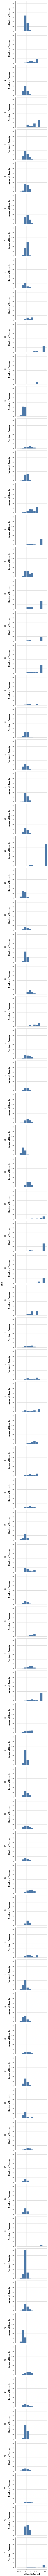

In [683]:
(alt.Chart(cluster_silhouettes)
    .mark_bar()
    .encode(x=alt.X('silhouette:Q', 
                    bin=alt.Bin(maxbins=20), 
                    axis=alt.Axis(grid=True)),
            y=alt.Y('count()'))
    .properties(width=180, height=180)
    .facet('label:N'))

,label,Aggregate,value
0,0,mean,0.087100
1,1,mean,0.385582
2,2,mean,0.050748
3,3,mean,0.417734
4,4,mean,0.096293


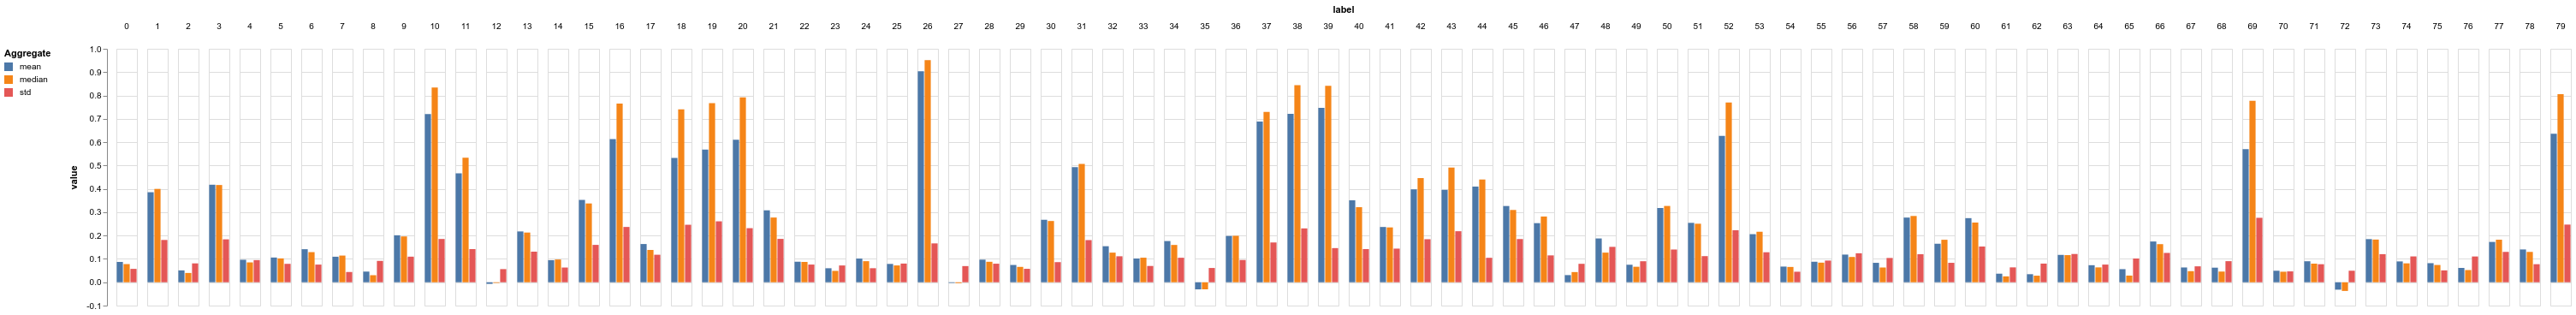

In [802]:
sil_group_stats = pd.DataFrame({
    'mean': g['silhouette'].mean(),
    'median': g['silhouette'].median(),
    'std': g['silhouette'].std()
}).reset_index().melt(var_name='Aggregate', id_vars='label')

display(sil_group_stats.head())

(alt.Chart(sil_group_stats)
    .mark_bar()
    .encode(x=alt.X('Aggregate:N', title=None, scale=alt.Scale(rangeStep=8), axis=None),
            y='value:Q',
            column='label:N',
            color=alt.Color('Aggregate:N', legend=alt.Legend(orient='left'))))


In [839]:
clusters = pd.DataFrame({'silhouette_mean': cluster_silhouettes.groupby('label').mean()['silhouette'], 
                        'top_terms': top_cluster_terms['top_terms']})
display(clusters.head())
clusters.shape


,silhouette_mean,top_terms
label,,
0,0.087100,"[to, the, his, and, in, letter, from, of, he, ..."
1,0.385582,"[birkat, mazon, ha, for, passover, hallel, and..."
2,0.050748,"[arabic, judaeo, in, hebrew, with, and, the, o..."
3,0.417734,"[roš, šana, additional, ha, ʿamida, service, f..."
4,0.096293,"[al, ibn, the, of, and, from, abū, on, kitāb, ..."


(80, 2)

In [765]:
reasonable_groups = cluster_silhouettes.groupby('label').mean().query('silhouette >= 0.2')
reasonable_groups

,silhouette
label,
1,0.385582
3,0.417734
9,0.201171
10,0.720455
11,0.466544
13,0.217628
15,0.352707
16,0.613305
18,0.532716


In [837]:
_labeled_descriptions = (pd.concat([pd.DataFrame(descriptions).reset_index(), 
           pd.Series(km.labels_, name='label')], axis=1))
cluster_members = _labeled_descriptions.groupby('label')
cluster_members.get_group(0).head()

,classmark,summary,label
147,MS-OR-01080-J-00080,Recto: petition to a Fatimid dignitary regardi...,0
154,MS-TS-AR-00004-00010,Recto: petition from a certain Jaʿfar to a Fat...,0
189,MS-TS-AR-00018-00001-00033,Letter from Moses the schoolmaster petitioning...,0
285,MS-TS-AR-00018-00001-00130,Letter sent to the market in Fusṭāṭ to the sho...,0
292,MS-TS-AR-00018-00001-00137,Letter from Manṣūr b. Sālim (stepbrother of El...,0


In [788]:
clusters.size().mean()

202.33333333333334

In [769]:
# 10 = unidentified text
# 16 = benedictions
# 79 = Seliḥot
# 73 = additional service
# 26 = passover haggada
clusters.get_group(26)

,classmark,summary,cluster,silhouette
2250,MS-LG-BIBLE-00006-00062,Passover Haggada. Plagues listed decoratively ...,26,0.904207
2832,MS-LG-TALMUD-00002-00029,Commentary on the Passover Haggada.,26,0.904207
3939,MS-MOSSERI-I-00033-00002,"Passover Haggada, with a few words from the fi...",26,0.904207
4046,MS-MOSSERI-I-00094-00001,"Passover Haggada, the end of the first introdu...",26,0.904207
4048,MS-MOSSERI-I-00095,"Passover Haggada, the opening and main body of...",26,0.904207
4049,MS-MOSSERI-I-00096-00001,"Passover Haggada, the opening and main body of...",26,0.904207
4054,MS-MOSSERI-I-00100-00001,"Passover Haggada, the midraš.",26,0.904207
4869,MS-OR-01080-00002-00044,Passover Haggada.,26,0.904207
4900,MS-OR-01080-00013-00013,Passover Haggada.,26,0.904207
4904,MS-OR-01080-00013-00053,Passover Haggada.,26,0.904207


In [792]:
%%html
foo

In [861]:
from IPython.core.display import HTML

In [800]:
HTML('<h1>Hi</h1>')

In [863]:
from html import escape as escape

def esc(x):
    return escape(str(x))

In [874]:
rendered_clusters = []

def render_member(member):
    classmark, summary = member[['classmark', 'summary']]
    
    return f'<tr><td><a href="https://cudl.lib.cam.ac.uk/view/{esc(classmark)}">{esc(classmark)}</a></td><td>{escape(summary)}</td></tr>'

for cluster, (silhouette, terms) in (clusters
                .sort_values('silhouette_mean', ascending=False)
                .query('silhouette_mean >= 0.2')
                .iterrows()):
    rendered_members = '\n'.join(render_member(member) 
                                 for _, member in cluster_members.get_group(cluster).iterrows())
    
    rendered_terms = ''.join(f'<code class="term">{esc(term)}</code> ' for term in terms)
    
    rendered_clusters.append(f'''
<h2>Cluster <strong>#{esc(cluster)}</strong> <small>(mean silhouette score: {silhouette:.2f})</small></h2>

<h3>Top terms</h3>

<div class="terms">
{rendered_terms}
</div>

<h3>Members</h3>

<table class="cluster-members">
<tr><th>Classmark</th><th>Description</th></tr>
{rendered_members}
</table>
    ''')

HTML('''
<style>
.terms .term {
  padding-left: 1em;
  padding-right: 1em;
}

table.cluster-members td, table.cluster-members th {
    overflow: hidden; 
    white-space: nowrap;
    text-align: left;
}
</style>
''' + f'''
<h1>Clusters</h1>

{''.join(rendered_clusters)}
''')

Classmark,Description
MS-LG-BIBLE-00006-00062,Passover Haggada. Plagues listed decoratively on ff. 1r-1v. Ff. 2r-2v contains Psalms 115:1-116:1 as part of the Passover Seder Hallel.
MS-LG-TALMUD-00002-00029,Commentary on the Passover Haggada.
MS-MOSSERI-I-00033-00002,"Passover Haggada, with a few words from the first introduction to the midraš."
MS-MOSSERI-I-00094-00001,"Passover Haggada, the end of the first introduction to the midraš."
MS-MOSSERI-I-00095,"Passover Haggada, the opening and main body of the midraš."
MS-MOSSERI-I-00096-00001,"Passover Haggada, the opening and main body of the midraš."
MS-MOSSERI-I-00100-00001,"Passover Haggada, the midraš."
MS-OR-01080-00002-00044,Passover Haggada.
MS-OR-01080-00013-00013,Passover Haggada.
MS-OR-01080-00013-00053,Passover Haggada.
